# Calibration of a End-of-Arm Camera

This exercise will describe how to calibrate a end-of-arm camera using marker-board detection.
The excercise is divided into the following steps.

1. Load recorded images.
2. Show marker detection results.
3. Solve for the calibration.
4. Analysis of results.

First lets have a look at the data.

Note: if the interactive viewer does not work you may have to restart the notebook with `%matplotlib widget` instead of `%matplotlib notebook`

Note: As of 2023-12, interactive matplotlib only works with older notebook versions so downgrade your versions with
`pip install "notebook<7"`
Start it in the command line via` jupyter notebook --port xxxx`.
Use the vs-code pop up to open jupyter in your local server.


In [1]:
%matplotlib notebook
# %matplotlib widget

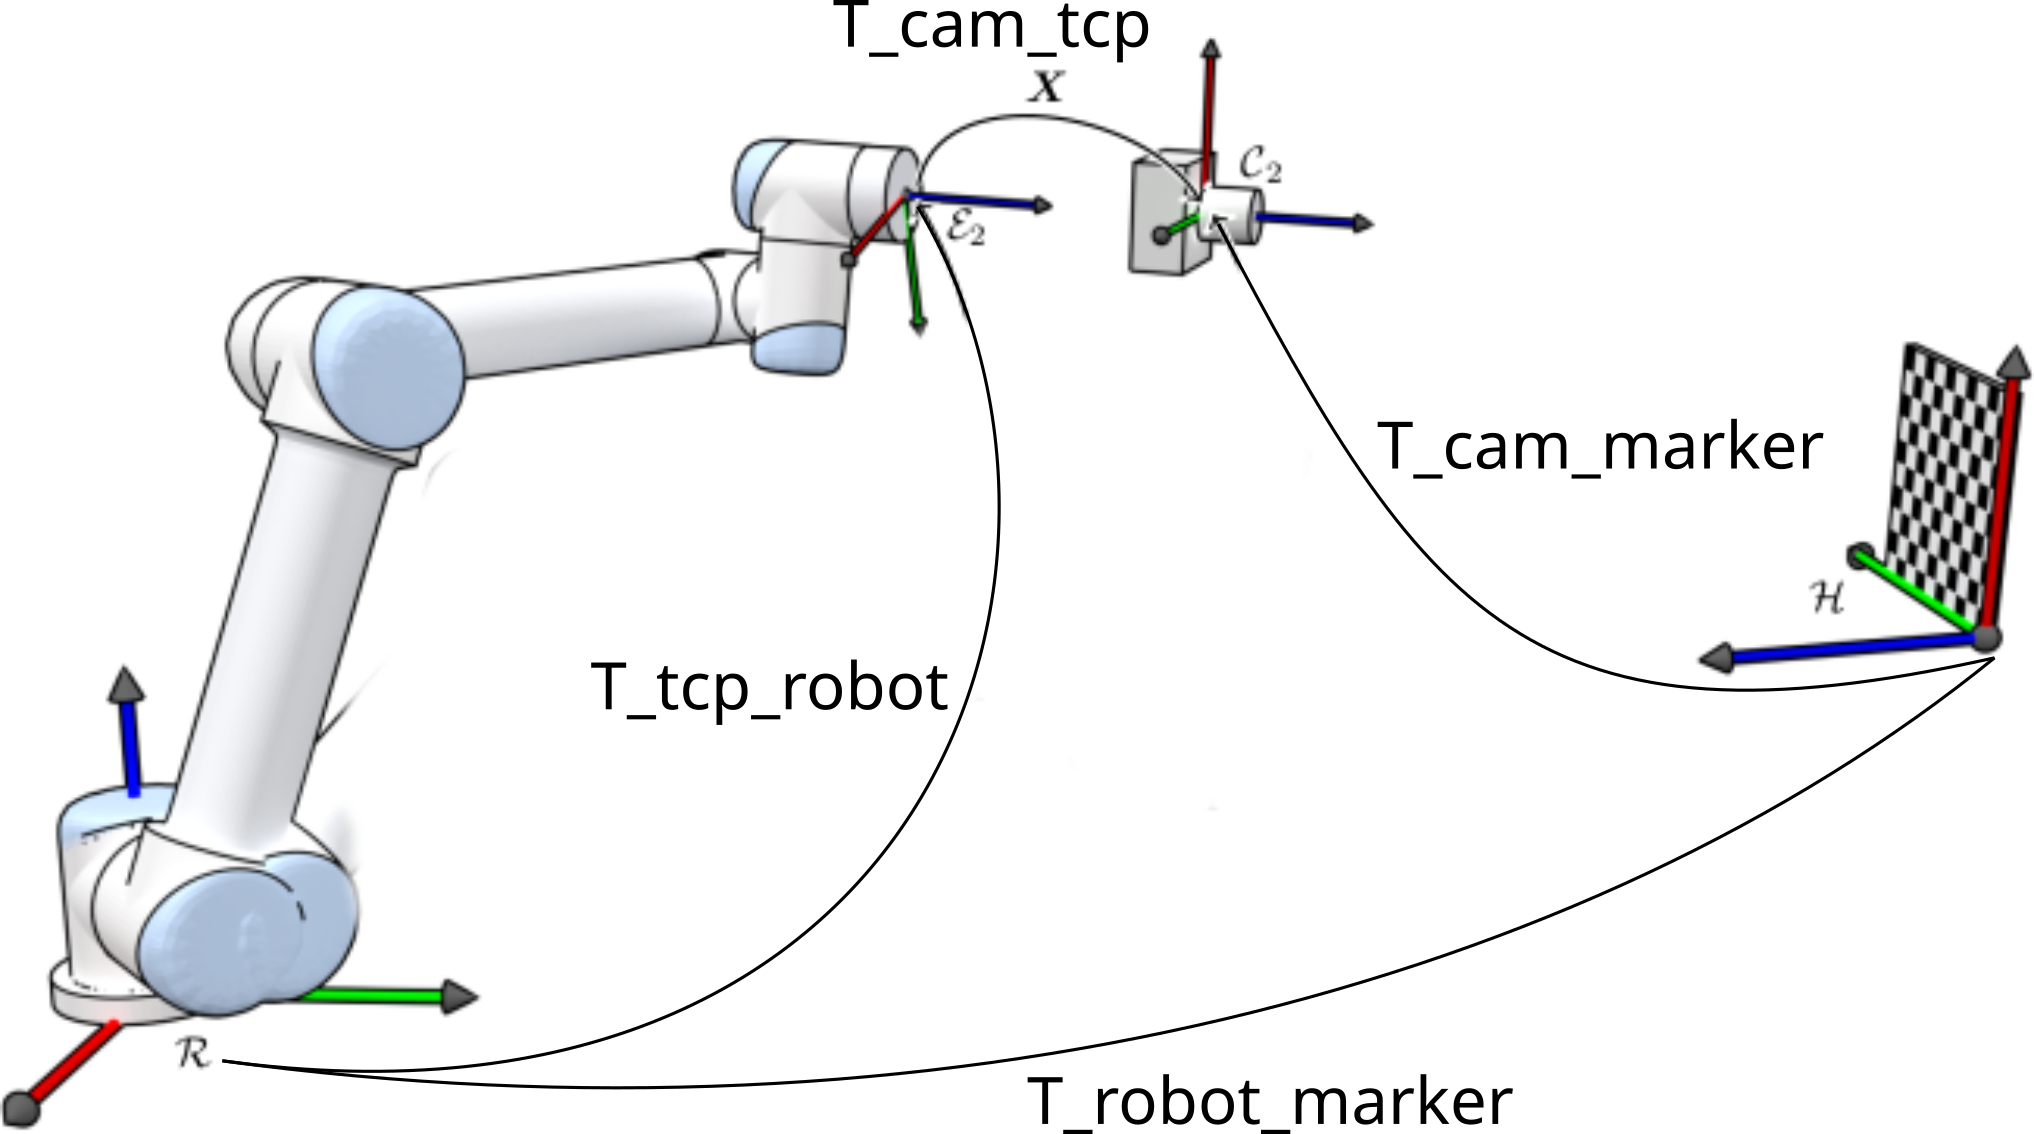

In [2]:
from IPython.display import Image

Image(filename="calibration_ls.png", width=1000)  # image adapted from torsteinmyhre.name

In this exercise want to do eye-in-hand extrinsic calibration. In this setup, a camera (eye) is mounted at end of a robot arm. The end of the robot arm is called Tool Center Point (TCP) because this is where tools are mounted. We would like to find the transformation `T_cam_tcp`. We do this calibration by moving the robot and taking several pictures of the marker board.

In the setup, the marker board, and the base of the robot are static, this means that `T_cam_tcp` as well as `T_robot_marker` are fixed. For each view recorded the robot arm is in a different location, which changes the position of the marker board as seen by the camera. This means that `T_tcp_robot` and `T_cam_marker` change for each view. Calibration works by finding a loop in these poses, and solving for `T_cam_tcp`. This can be done in several ways, in this exercise we present two methods, a simple least-squares optimization and the peak-martin algorithm.

In [3]:
import os
import tarfile
import io
import logging
from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.spatial.transform import Rotation
from PIL import Image

import open3d as o3d

log = logging.getLogger(__name__)
np.set_printoptions(suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Below code will download the data. Alternatively you can find it in `/project/.../shared-data/marker`

In [4]:
target_path = Path(".")
if not (target_path / "marker").is_dir():
    url = "https://lmb.informatik.uni-freiburg.de/people/argusm/marker.tar"
    print(f"Downloading {url}")
    res = requests.get(url, timeout=30)
    data = res.content
    data_io = io.BytesIO(data)
    with tarfile.TarFile(fileobj=data_io, mode="r") as tar:
        tar.extractall(path=target_path.as_posix())
else:
    print(f"Folder exists: {target_path.as_posix()}/marker")

Folder exists: ./marker


# 1. Load Recorded Images

This cell defines a data class that loads images and data from files.

Please complete the `get_projection_matrix` function.

In [5]:
class ViewLoader:
    def __init__(self, base_path):
        self.base_path = base_path
        assert os.path.isdir(base_path)
        files = sorted(os.listdir(self.base_path))
        files = [f for f in files if (f.startswith("rgb_") and f.endswith(".png"))]
        self.max_idx = int(files[-1].replace("rgb_", "").replace(".png", ""))
        print(f"Loaded {self.max_idx+1} images.")

    def __len__(self):
        return self.max_idx + 1

    def __getitem__(self, idx):
        return self.get_rgbdp(idx)

    def get_info(self):
        # read given parameters from info.json
        info_path = os.path.join(self.base_path, "info.json")
        with open(info_path, "rb") as f_obj:
            info = json.load(f_obj)
        return info

    def get_intrinsics(self):
        # get intrintic camera matrix
        info = self.get_info()
        calib = info["camera"]["calibration"]
        return calib

    def get_K(self):
        calib = self.get_intrinsics()
        cam_intrinsic = np.eye(3)
        cam_intrinsic[0, 0] = calib["fx"]
        cam_intrinsic[1, 1] = calib["fy"]
        cam_intrinsic[0, 2] = calib["ppx"]
        cam_intrinsic[1, 2] = calib["ppy"]
        return cam_intrinsic

    def get_robot_pose(self, idx, return_dict=False):
        # read robot pose, convert to 4x4 homogeneous format
        # returns T_robot_tcp
        pose_file = os.path.join(self.base_path, "pose_{0:04d}.json".format(idx))
        with open(pose_file, "rb") as f_obj:
            pose = json.load(f_obj)

        # pose contains position xyz, rotation xyz and depth (7 parameters)
        pose_m = np.eye(4)
        pose_m[:3, :3] = Rotation.from_euler(
            "xyz", [pose[x] for x in ["rot_x", "rot_y", "rot_z"]]
        ).as_matrix()
        pose_m[:3, 3] = [pose[x] for x in ["x", "y", "z"]]
        if return_dict:
            return pose_m, pose
        else:
            return pose_m

    def get_rgb_file(self, idx):
        # read RGB image
        rgb_file = os.path.join(self.base_path, "rgb_{0:04d}.png".format(idx))
        return rgb_file

    def get_depth_file(self, idx):
        # read depth image
        depth_file = os.path.join(self.base_path, "depth_{0:04d}.png".format(idx))
        return depth_file

    def get_rgbdp(self, idx):
        # get RGB, scaled-depth, robot pose
        rgb_file = self.get_rgb_file(idx)
        rgb = np.asarray(Image.open(rgb_file))

        pose_m, pose_d = self.get_robot_pose(idx, True)

        # depth images here are saved 16-bit grayscale for efficient storage
        # depth_scaling is the factor required to convert depth to meters
        depth_file = self.get_depth_file(idx)
        depth_scaling = pose_d["depth_scaling"]
        depth = np.asarray(Image.open(depth_file), dtype=np.float32) * depth_scaling
        return rgb, depth, pose_m

    def get_cam_pose(self, idx, marker_dir="pose_marker_one"):
        # get camera pose in 4x4 homogeneous format
        # these are the results from marker detection: T_cam_marker
        marker_dir = os.path.join(self.base_path, marker_dir)
        fn = "{0:08d}.json".format(idx)
        pose_fn = os.path.join(marker_dir, fn)
        with open(pose_fn, "r") as fo:
            T_cam_marker = np.array(json.load(fo))
        return T_cam_marker

    def get_projection_matrix(self):
        # returns a 3x4 projection matrix using the intrinsics
        # it projects a 2d point in in homogeneous coordinates
        # to a 3d point in homogeneous coordinates
        # assuming the camera frame and world frame are aligned

        # START TODO #################
        # intr = self.get_intrinsics()
        # ...
        intr = self.get_intrinsics()
        cam_mat = np.array(
            [[intr["fx"], 0, intr["ppx"], 0], [0, intr["fy"], intr["ppy"], 0], [0, 0, 1, 0]]
        )
        # END TODO ###################
        assert cam_mat.shape == (3, 4)
        return cam_mat

    def project(self, X):
        if X.shape[0] == 3:
            # convert coordinate to homogeneous if it is euclidean
            if len(X.shape) == 1:
                X = np.append(X, 1)
            else:
                X = np.concatenate([X, np.ones((1, X.shape[1]))], axis=0)

        # project a point from the 3d camera coordinate system into
        # the 2d camera frame. (in homogeneous coordinates)
        x = self.get_projection_matrix() @ X

        # convert homogeneous to euclidean and check if it is inside the image boundaries
        result = np.round(x[0:2] / x[2]).astype(int)
        width, height = self.get_intrinsics()["width"], self.get_intrinsics()["height"]
        if not (0 <= result[0] < width and 0 <= result[1] < height):
            log.warning("Projected point outside of image bounds")
        return result[0], result[1]


vl = ViewLoader(base_path="marker")
print("camera calibration:")
camera_calibration = vl.get_K()
K = np.array(camera_calibration)
print(K.round(2))

Loaded 50 images.
camera calibration:
[[616.2    0.   311.53]
 [  0.   616.2  235.69]
 [  0.     0.     1.  ]]


<IPython.core.display.Javascript object>


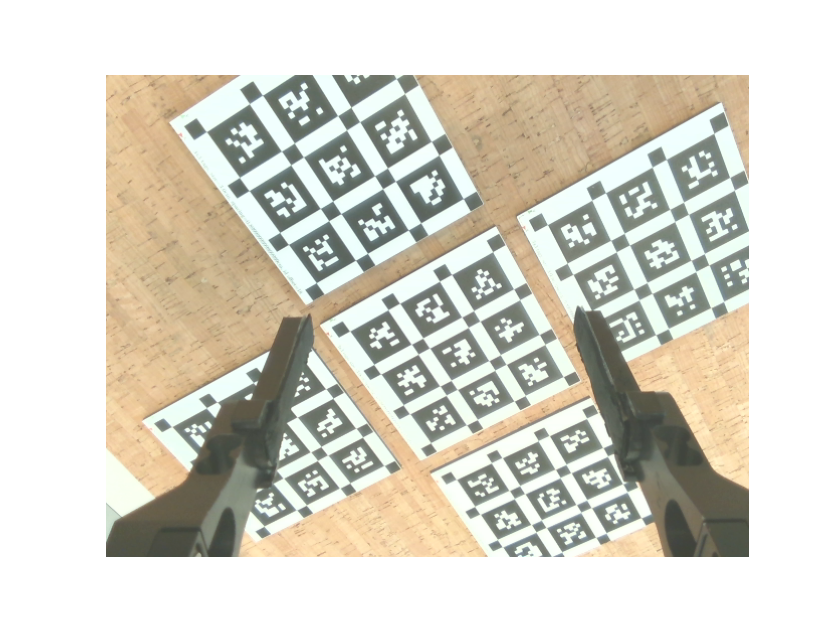

interactive(children=(IntSlider(value=0, description='w', layout=Layout(width='70%'), max=49), Output()), _dom…

In [6]:
from ipywidgets import widgets, Layout, interact

fig, ax = plt.subplots(1)
image, depth, pose = vl.get_rgbdp(0)
line = ax.imshow(np.asarray(image))
ax.set_axis_off()


def update(w):
    image, depth, pose = vl.get_rgbdp(w)
    line.set_data(np.asarray(image))
    fig.canvas.draw_idle()


slider_w = widgets.IntSlider(min=0, max=len(vl) - 1, step=1, value=0, layout=Layout(width="70%"))
interact(update, w=slider_w)
pass

# 2. Show Marker Detection Results.

To simplify things marker detection has already been run. Next we want to verify its results.
Do this by drawing a coordinate frame into each image for which we have detection results.
The coordinate frame should have axis lengths of 10cm, with x=red, y=green, and z=blue.
This can be done using `PIL.ImageDraw`.

<IPython.core.display.Javascript object>


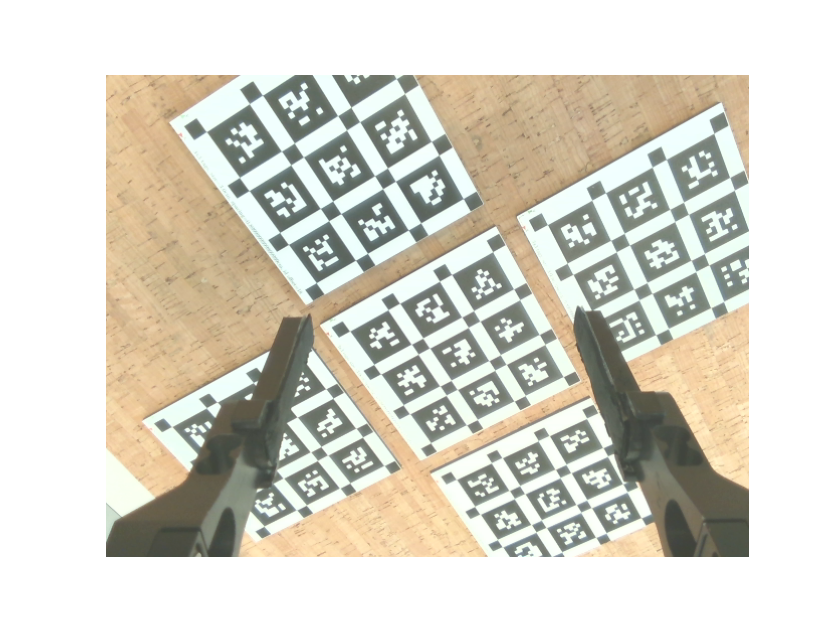

[[-0.15241697  0.97575408  0.15707652 -0.06449104]
 [ 0.92119719  0.08268919  0.38020815  0.04840028]
 [ 0.35800112  0.20264862 -0.91146516  0.36549392]
 [ 0.          0.          0.          1.        ]]
(203, 317) (189, 451) (364, 326) (202, 430)


interactive(children=(IntSlider(value=0, description='w', layout=Layout(width='70%'), max=49), Output()), _dom…

In [7]:
from PIL import ImageDraw


def show_marker_pose(image, T_cam_marker):
    """
    draw the coordinate frame into each image for which we have detection results
    Arguments:
        image: image as numpy.ndarray
        T_cam_marker: shape (4, 4), transform from marker into camera
            x_cam = T_cam_marker @ x_marker
    Returns:
        im: image (should be PIL.Image.Image)
    """
    print(T_cam_marker)
    # START TODO #################
    # using PIL.ImageDraw
    # 1. Define 4 points in 3D homogeneous coordinates: <x, y, z, center>
    #    (The center of the coordinate system and a point for each of 3 axes.)
    #    Note that the 3D here are specified in meters.
    # 2. Transform the <x, y, z, center> coordinates into the camera frame
    # 3. Project the homogeneous coordinates <cam_x, cam_y, cam_z, center>
    #    to the camera image (euclidean)
    # 4. Draw one line for each axis

    center = np.array([0, 0, 0, 1])
    x = np.array([0.1, 0, 0, 1])
    y = np.array([0, 0.1, 0, 1])
    z = np.array([0, 0, 0.1, 1])

    object_cam = T_cam_marker @ center
    x_cam = T_cam_marker @ x
    y_cam = T_cam_marker @ y
    z_cam = T_cam_marker @ z

    object_cam_p = vl.project(object_cam)
    x_cam_p = vl.project(x_cam)
    y_cam_p = vl.project(y_cam)
    z_cam_p = vl.project(z_cam)
    print(object_cam_p, x_cam_p, y_cam_p, z_cam_p)

    # # alternatively you could calculate the projection matrix P first with P=KM
    # K = vl.get_K()
    # M = T_cam_marker[:3, :]
    # P = K @ M
    # # and directly project
    # cp = P @ center
    # xp = P @ x
    # yp = P @ y
    # zp = P @ z
    # # convert back to euclidean coordinates
    # object_cam_p = np.round(cp[0:2] / cp[2]).astype(int).tolist()
    # x_cam_p = np.round(xp[0:2] / xp[2]).astype(int).tolist()
    # y_cam_p = np.round(yp[0:2] / yp[2]).astype(int).tolist()
    # z_cam_p = np.round(zp[0:2] / zp[2]).astype(int).tolist()
    # print(object_cam_p, x_cam_p, y_cam_p, z_cam_p)

    im = Image.fromarray(image)
    draw = ImageDraw.Draw(im)
    draw.line(object_cam_p + x_cam_p, fill="red", width=5)
    draw.line(object_cam_p + y_cam_p, fill="green", width=5)
    draw.line(object_cam_p + z_cam_p, fill="blue", width=5)
    # END TODO ###################

    # type(im) should be PIL.Image.Image
    return im


image, depth, robot_pose = vl.get_rgbdp(1)
T_cam_marker = vl.get_cam_pose(1)

fig, ax = plt.subplots(1)
image_m = show_marker_pose(image, T_cam_marker)
line = ax.imshow(np.asarray(image_m))
ax.set_axis_off()


def update(w):
    image, depth, pose = vl.get_rgbdp(w)
    try:
        T_cam_marker = vl.get_cam_pose(w)
    except FileNotFoundError:
        print("No pose estimation.")
        line.set_data(np.asarray(image))
        return
    image_m = show_marker_pose(image, T_cam_marker)
    line.set_data(np.asarray(image_m))
    fig.canvas.draw_idle()


slider_w = widgets.IntSlider(min=0, max=len(vl) - 1, step=1, value=0, layout=Layout(width="70%"))
interact(update, w=slider_w)
pass


In [8]:
def get_tcp_marker_lists(m_dir="pose_marker_one"):
    T_robot_tcp_list = []
    T_cam_marker_list = []
    for i in range(len(vl)):
        try:
            robot_pose = vl.get_robot_pose(i)
            cam_pose = vl.get_cam_pose(i, marker_dir=m_dir)
        except (FileNotFoundError, ValueError):
            continue
        T_robot_tcp_list.append(robot_pose)
        T_cam_marker_list.append(cam_pose)

    return np.array(T_robot_tcp_list), np.array(T_cam_marker_list)


# draw the markers in 3d
import open3d as o3d

plot_o3d = True
# plot_o3d = False
if plot_o3d:
    T_robot_tcp_list, T_cam_marker_list = get_tcp_marker_lists()
    # create one big frame to show the absolute zero point of the plot
    mesh_frames = []
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
    mesh_frames.append(mesh_frame)

    for T_robot_tcp, T_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        # create coordinate frames around the zero point and transform them
        # to visualize the transforms

        # # T_robot_tcp shows where the tool is relative to the robot base (small arrows)
        mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
        mesh_frame.transform(T_robot_tcp)
        mesh_frames.append(mesh_frame)

        # # you can also view the robot base relative to the tool
        # T_tcp_robot = np.linalg.inv(T_robot_tcp)
        # mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
        # mesh_frame.transform(T_tcp_robot)
        # mesh_frames.append(mesh_frame)

        # # shows where the cam is relative to the marker (big arrows)
        T_marker_cam = np.linalg.inv(T_cam_marker)
        mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
        mesh_frame.transform(T_marker_cam)
        mesh_frames.append(mesh_frame)

        # # shows where the marker is relative to the cam
        # mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.20)
        # mesh_frame.transform(T_cam_marker)
        # mesh_frames.append(mesh_frame)

    # Draw the geometries
    o3d.visualization.draw_geometries(mesh_frames)

# 3. Solve for the Calibration

We will try to find the calibration using two different methods, via least squares optimization and using the park martin algorithm.

In [9]:
def vec_to_matrix(x):
    """
    Args:
        x: is our optimization target, a vector of shape (9,).
            [0:3] position transform of T_cam_tcp
            [3:6] rotation transform of T_cam_tcp
                (angles to rotate around xyz axes)
            [6:9] position transform of T_robot_marker (discarded here)

    Returns:
        transformation matrix T_cam_tcp shape (4, 4)

    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html
    """
    mat = np.eye(4)
    mat[:3, 3] = x[0:3]
    mat[:3, :3] = Rotation.from_euler("xyz", x[3:6]).as_matrix()
    return mat


def pprint(arr):
    return np.array2string(arr.round(5), separator=", ")


def matrix_to_pos_orn(mat):
    """
    Args:
        mat: 4x4 homogeneous transformation

    Returns:
        position: np.array of shape (3,),
        orientation: np.array of shape (4,) -> quaternion xyzw

    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_quat.html
    """
    orn = Rotation.from_matrix(mat[:3, :3]).as_quat()
    pos = mat[:3, 3]
    return pos, orn


def pose_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list):
    """
    returns position error tuple for each entry
    
    Explanation: We know that T_robot_marker is constant.
    Given our calibrated T_tcp_cam we calculate T_robot_marker for each pair
    of robot position T_robot_tcp and marker detection result T_cam_marker.
    Now assuming perfect marker detection, robot position and calibration,
    the calculated T_robot_marker should be the same for all pairs.
    Therefore we can use derivations of the mean pose as pose error.

    Args:
        T_tcp_cam: Transform from camera to tool center shape (4, 4)
        T_robot_tcp_list: List of robot poses i.e. transform from tool center
            point to robot base, shape (N, 4, 4)
        T_cam_marker_list: List of marker measurements i.e. transform from
            marker to camera, shape (N, 4, 4)
    Returns:
        error: cartesian error (N, 3)
    """
    T_robot_marker_list = []
    for T_robot_tcp, T_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        T_robot_marker = T_robot_tcp @ T_tcp_cam @ T_cam_marker
        T_robot_marker_list.append(T_robot_marker)

    poses = np.array(T_robot_marker_list)[:, :3, 3]
    err = poses - np.mean(poses, axis=0)
    return err

## Least-Squares Optimization

`T_robot_marker` and `T_cam_tcp` are fixed but unknown, so these will be used as variables that have to be optimized.
From these values compute the predicted `T_cam_marker_pred` and compare it to `T_cam_marker_obs`.
Since we have enough measurements, we can do the comparison based only on position values (i.e. it is enough to predict how the origin moves between the coordinate systems), so `T_robot_marker` only uses position components.
Optimize the function using `scipy.optimize.least_squares`.

`T_cam_marker = T_cam_tcp @ T_tcp_robot @ T_robot_marker`

In [10]:
from scipy.optimize import least_squares, minimize


def compute_residuals_gripper_cam(x, T_robot_tcp_list, T_cam_marker_list):
    """
    Calculate predicted positional transform from marker to camera using
    T_cam_tcp, T_robot_marker and T_tcp_robot.
    Compare these predicted values with the observed positional transform
    T_cam_marker to calculate and returns the residuals

    Args:
        x: is our optimization target, a vector of shape (9,).
            [0:3] position transform of T_cam_tcp
            [3:6] rotation transform of T_cam_tcp
                (angles to rotate around xyz axes)
            [6:9] position transform of T_robot_marker
        T_robot_tcp_list: List of robot poses i.e. transform from tool center
            point to robot base, each entry shape (4, 4)
        T_cam_marker_list: List of marker measurements i.e. transform from
            marker to camera, each entry shape (4, 4)

    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
    """
    T_robot_marker = np.array([*x[6:], 1])  # shape (4, )
    T_cam_tcp = vec_to_matrix(x)  # shape (4, 4)

    # START TODO #################
    residuals = []
    for i in range(T_cam_marker_list.shape[0]):
        T_cam_marker = T_cam_marker_list[i]
        T_cam_marker_pos_obs = T_cam_marker[:3, 3]  # shape(3,)

        T_robot_tcp = T_robot_tcp_list[i]
        T_tcp_robot = np.linalg.inv(T_robot_tcp)
        T_cam_marker_pred = T_cam_tcp @ T_tcp_robot @ T_robot_marker
        #                   (4, 4)    @ (4, 4)      @ (4,)

        # # instead we could also assume T_robot_marker as a transform shape (4, 4) without rotation
        # # then compute T_cam_marker_pred shape (4, 4)
        # # and compute the residual only on the positional part.
        
        # T_robot_marker_44 = np.eye(4, dtype=np.float64)
        # T_robot_marker_44[:, 3] = T_robot_marker
        # T_cam_marker_pred_44 = T_cam_tcp @ T_tcp_robot @ T_robot_marker_44
        # T_cam_marker_pred = T_cam_marker_pred_44[:, 3]

        residuals += list(T_cam_marker_pos_obs - T_cam_marker_pred[:3])
    # END TODO ###################

    # len(residuals) will be 144 = 48 samples * 3 (x,y,z), for least-squares optimization
    return residuals


def calibrate_gripper_cam_ls(T_robot_tcp_list, T_cam_marker_list):
    # use scipy least squares to optimize the above function and return the calibration
    # START TODO #################
    x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, -0.1])
    result = least_squares(
        fun=compute_residuals_gripper_cam,
        x0=x0,
        method="lm",
        args=(T_robot_tcp_list, T_cam_marker_list),
    )
    T_cam_tcp = vec_to_matrix(result.x)
    T_tcp_cam = np.linalg.inv(T_cam_tcp)
    # END TODO ###################

    assert T_tcp_cam.shape == (4, 4)
    return T_tcp_cam


T_robot_tcp_list, T_cam_marker_list = get_tcp_marker_lists()
T_tcp_cam = calibrate_gripper_cam_ls(T_robot_tcp_list, T_cam_marker_list)
err_ls = pose_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list)
err_ls_s = np.sum(err_ls**2, axis=1)
# analyze median error since that is more robust to outliers than mean error
print("median error ls", np.median(err_ls_s))

median error ls 7.868464765293446e-07


In [11]:
# Try to slighty improve the result using differential evolution
# nothing required here.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html


def calculate_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list, inliers=None):
    """
    Args:
        T_tcp_cam: Transform from camera to tool center shape (4,4)
        T_robot_tcp_list: List of robot poses i.e. transform from tool center
            point to robot base, shape (N, 4, 4)
        T_cam_marker_list: List of marker measurements i.e. transform from
            marker to camera, shape (N, 4, 4)
    Returns:
        scalar error for each entry
    """
    T_robot_marker_list = []
    for T_robot_tcp, T_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        T_robot_marker = T_robot_tcp @ T_tcp_cam @ T_cam_marker
        T_robot_marker_list.append(T_robot_marker)

    poses = np.array(T_robot_marker_list)[:, :3, 3]
    if inliers is None:
        mean_pose = np.mean(poses, axis=0)
    else:
        mean_pose = np.mean(poses[inliers], axis=0)
    err = np.sum((poses - mean_pose) ** 2, axis=1)
    return err


import scipy


def calibrate_gripper_cam_de(T_robot_tcp_list, T_cam_marker_list):
    # optimize using least squares as before
    x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, -0.1])
    result = least_squares(
        fun=compute_residuals_gripper_cam,
        x0=x0,
        method="lm",
        args=(T_robot_tcp_list, T_cam_marker_list),
    )

    x0 = result.x
    bounds = [(x - 0.0001, x + 0.0001) for x in x0]

    def func(x, *args):
        T_cam_tcp = vec_to_matrix(x)
        return calculate_error(T_cam_tcp, *args).mean()

    result2 = scipy.optimize.differential_evolution(
        func=func,
        bounds=bounds,
        args=(T_robot_tcp_list, T_cam_marker_list),
        tol=1e-11,
    )
    T_tcp_cam = np.linalg.inv(vec_to_matrix(result2.x))
    # print(result.x)
    # print(bounds)
    return T_tcp_cam


T_tcp_cam = calibrate_gripper_cam_de(T_robot_tcp_list, T_cam_marker_list)
err_ls = pose_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list)
err_ls_s = np.sum(err_ls**2, axis=1)
print("median error ls", np.median(err_ls_s))

median error ls 7.746895588444993e-07


# Park-Martin Calibration

Have a look here for the description of the Park-Martin method.

https://www.torsteinmyhre.name/snippets/robcam_calibration.html

We are trying to solve the following equation: `AX = XB`. The website shows how to create the lists `As`,`Bs`.
This is an example for another method to solve the problem posed in this exercise.

In [12]:
import itertools


def log_func(R):
    # Rotation matrix logarithm
    theta = np.arccos((R[0, 0] + R[1, 1] + R[2, 2] - 1.0) / 2.0)
    return (
        np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])
        * theta
        / (2 * np.sin(theta))
    )


def invsqrt(mat):
    u, s, v = np.linalg.svd(mat)
    return u.dot(np.diag(1.0 / np.sqrt(s))).dot(v)


def calibrate(A, B):
    # transform pairs A_i, B_i
    N = len(A)
    M = np.zeros((3, 3))
    for i in range(N):
        Ra, Rb = A[i][0:3, 0:3], B[i][0:3, 0:3]
        M += np.outer(log_func(Rb), log_func(Ra))

    Rx = np.dot(invsqrt(np.dot(M.T, M)), M.T)

    C = np.zeros((3 * N, 3))
    d = np.zeros((3 * N, 1))
    for i in range(N):
        Ra, ta = A[i][0:3, 0:3], A[i][0:3, 3]
        Rb, tb = B[i][0:3, 0:3], B[i][0:3, 3]
        C[3 * i : 3 * i + 3, :] = np.eye(3) - Ra
        d[3 * i : 3 * i + 3, 0] = ta - np.dot(Rx, tb)

    tx = np.dot(np.linalg.inv(np.dot(C.T, C)), np.dot(C.T, d))
    X = np.eye(4)
    X[:3, :3] = Rx
    X[:3, 3] = tx.flatten()
    return X


def calibrate_gripper_cam_peak_martin(T_robot_tcp_list, T_cam_marker_list):
    ECs = []
    for T_robot_tcp, t_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        T_tcp_robot = np.linalg.inv(T_robot_tcp)
        ECs.append((T_tcp_robot, t_cam_marker))

    As = []  # relative EEs
    Bs = []  # relative cams
    for pair in itertools.combinations(ECs, 2):
        (e_1, c_1), (e_2, c_2) = pair
        A = e_2 @ np.linalg.inv(e_1)
        B = c_2 @ np.linalg.inv(c_1)
        As.append(A)
        Bs.append(B)

        # symmetrize
        A = e_1 @ np.linalg.inv(e_2)
        B = c_1 @ np.linalg.inv(c_2)
        As.append(A)
        Bs.append(B)

    X = calibrate(As, Bs)
    return X

# 4. Analysis of results

Lets have a look at the results of both methods. 

1. How much does each datapoint contribute to the overall error? How much does each cartesian dimension contribute to the overall error?
2. Does the error correlate with distance from the camera?
3. How do the results change if we remove high error datapoints?

In [13]:
from timeit import default_timer

T_robot_tcp_list, T_cam_marker_list = get_tcp_marker_lists()

t1 = default_timer()
T_tcp_cam = calibrate_gripper_cam_ls(T_robot_tcp_list, T_cam_marker_list)
print(f"LS: {default_timer() - t1:.6f}s")

err_ls = pose_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list)
err_ls_s = np.sum(err_ls**2, axis=1)
print("median error ls", np.median(err_ls_s))

t1 = default_timer()
T_tcp_cam = calibrate_gripper_cam_peak_martin(T_robot_tcp_list, T_cam_marker_list)
print(f"PM: {default_timer() - t1:.6f}s")

err_pm = pose_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list)
err_pm_s = np.sum(err_pm**2, axis=1)
print("median error pm", np.median(err_pm_s))

# timing measurement is slightly inaccurate but shows that PM is a bit faster.
# to get more accurate measurements e.g. run the methods 100 times and average.

LS: 0.108280s
median error ls 7.868464765293446e-07
PM: 0.107421s
median error pm 1.237446490846659e-06


<IPython.core.display.Javascript object>


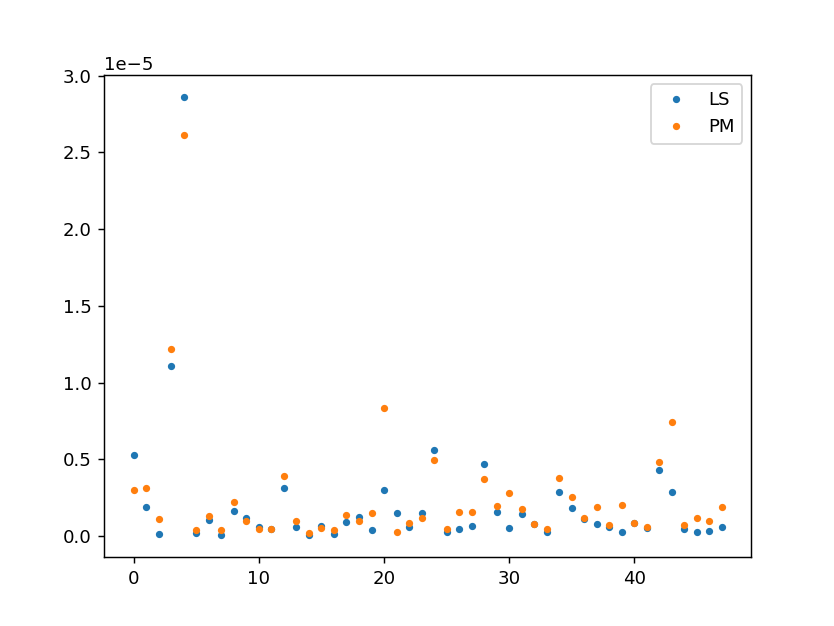

<IPython.core.display.Javascript object>


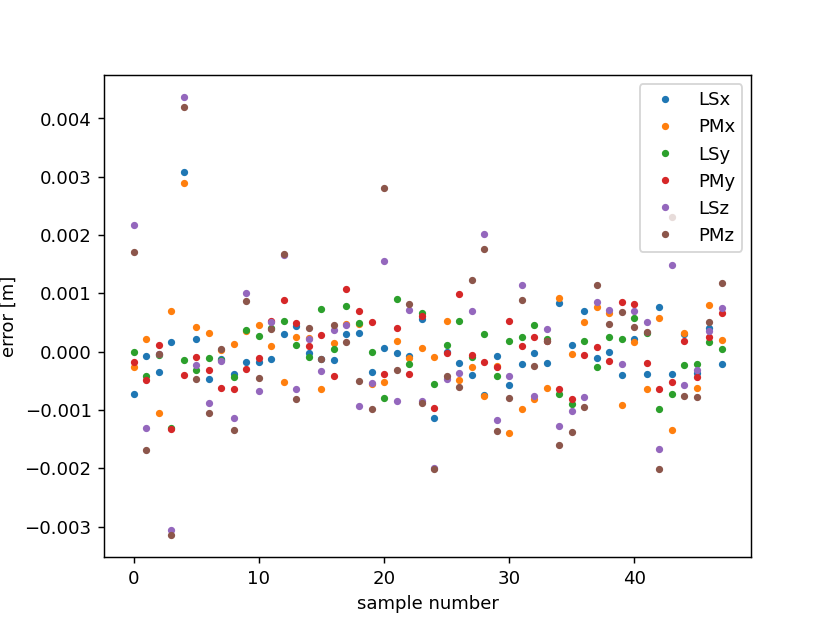

[0.16911235 0.11105049 0.71983717]
[0.19923462 0.11273095 0.68803443]


In [14]:
# START TODO #################
# 1. plot errors for each datapoint and method
# 2. plot errors for each datapoint, method and axis
fig, ax = plt.subplots(1)
ax.plot(err_ls_s, ".", label="LS")
ax.plot(err_pm_s, ".", label="PM")
ax.legend()

fig, ax = plt.subplots(1)
for i, a in enumerate(list("xyz")):
    ax.plot(err_ls[:, i], ".", label="LS" + a)
    ax.plot(err_pm[:, i], ".", label="PM" + a)

ax.set_xlabel("sample number")
ax.set_ylabel("error [m]")
ax.legend()
plt.show()

tmp = np.sum(err_ls**2, axis=0)
print(tmp / np.sum(tmp))
tmp = np.sum(err_pm**2, axis=0)
print(tmp / np.sum(tmp))
# END TODO ###################

## Error-Depth Correlation

Does the error correlate with distance from the camera?


pearsonr: -0.47430 p: 0.00066


<IPython.core.display.Javascript object>


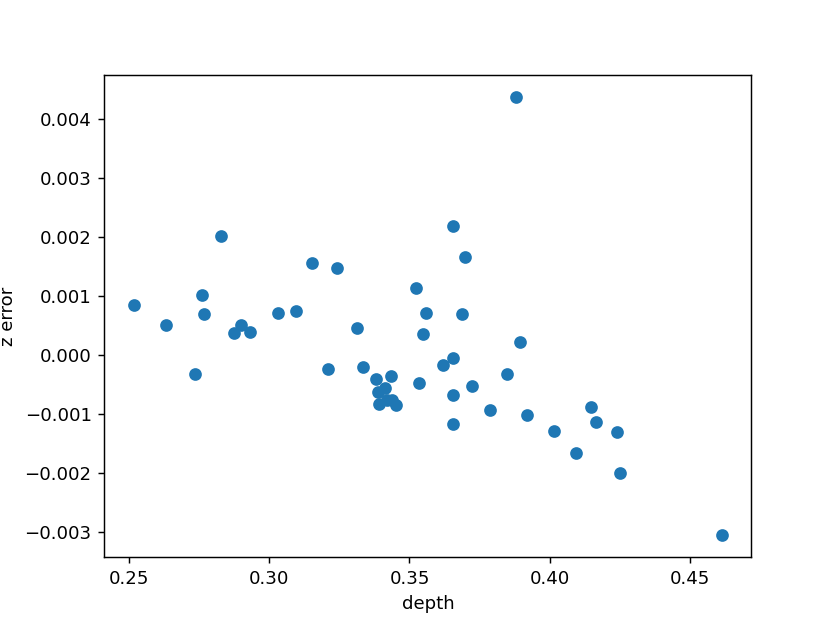

In [15]:
# START TODO #################
from scipy.stats import pearsonr

# T_cam_marker_list shape (N, 4, 4) are the transforms from marker to camera
# position [2, 3] in a transform matrix is the Z-translation
depth_marker = T_cam_marker_list[:, 2, 3]
err_z = err_ls[:, 2]

# calculate pearson correlation coefficient
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
pearsonr_stat, pearsonr_p = pearsonr(depth_marker, err_z)
print(f"pearsonr: {pearsonr_stat:.5f} p: {pearsonr_p:.5f}")

fig, ax = plt.subplots(1)
ax.scatter(depth_marker, err_z)
ax.set_xlabel("depth")
ax.set_ylabel("z error")
plt.show()
# END TODO ###################

## 4.3 Remove High-Error Samples.

How do the results change if we remove high error datapoints?

<IPython.core.display.Javascript object>


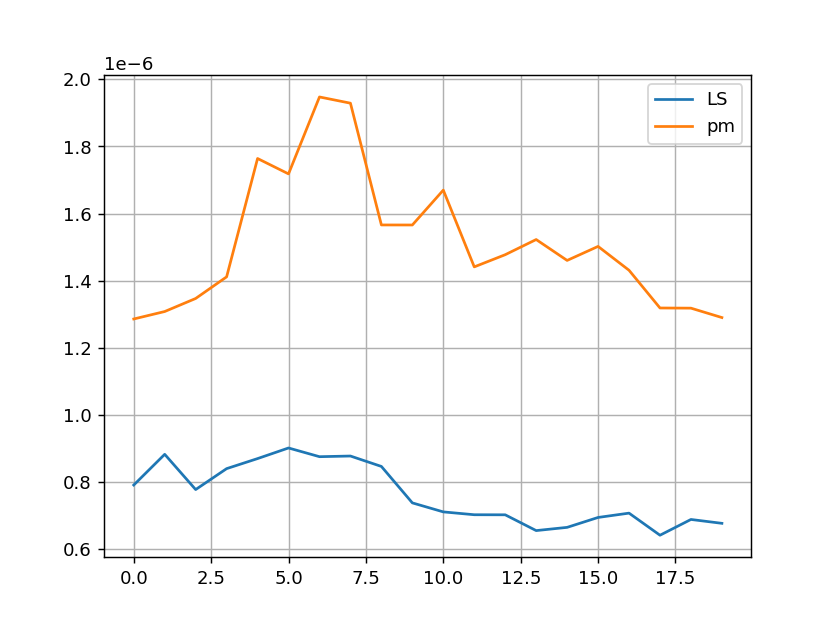

48 7.913e-07 [-0.00116909  0.12447644 -0.19626356] [  30.08912216    2.34104167 -177.76439069]
47 8.829e-07 [-0.00232129  0.12439426 -0.19605086] [  30.04021209    2.50533906 -177.59002195]
46 7.778e-07 [-0.00245571  0.1241288  -0.19623272] [  29.9900857     2.52309128 -177.5643183 ]
45 8.402e-07 [-0.00301914  0.12413002 -0.19600171] [  29.97927329    2.60743431 -177.50805731]
44 8.701e-07 [-0.00311377  0.12391062 -0.19590066] [  29.93889655    2.62447936 -177.51700819]
43 9.017e-07 [-0.00330354  0.12393173 -0.19590025] [  29.94092379    2.6553392  -177.52305072]
42 8.758e-07 [-0.00322677  0.1240086  -0.19582093] [  29.95996469    2.64428473 -177.51536747]
41 8.777e-07 [-0.00333881  0.12431398 -0.195357  ] [  30.0119373     2.65866368 -177.46426833]
40 8.467e-07 [-0.0029493   0.12410296 -0.19562885] [  29.96652428    2.59436149 -177.48185298]
39 7.381e-07 [-0.00182069  0.12386483 -0.19589091] [  29.91901773    2.42075481 -177.57666453]
38 7.113e-07 [-0.00161676  0.12373983 -0.19599781]

In [16]:
# START TODO #################
def eval_subset(T_robot_tcp_list, T_cam_marker_list, calib_func, name=""):
    median_scores = []
    inliers = np.ones(T_robot_tcp_list.shape[0], dtype=bool)
    for i in range(20):
        T_tcp_cam = calib_func(T_robot_tcp_list[inliers], T_cam_marker_list[inliers])
        err_ls = calculate_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list)
        median_score = sorted(err_ls)[T_robot_tcp_list.shape[0] // 2]
        median_scores.append(median_score)

        # calculate position and rotation of the solution for display
        pos, orn = matrix_to_pos_orn(T_tcp_cam)
        rot_deg = Rotation.from_quat(orn).as_euler("XYZ", degrees=True)

        print(f"{np.sum(inliers)} {median_score:7.3e} {pos} {rot_deg}")
        err_ls = calculate_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list)
        inliers = err_ls < sorted(err_ls)[-1 * (i + 1)]

    plt.plot(median_scores, label=name)
    print("done.")


fig, ax = plt.subplots(1)
eval_subset(T_robot_tcp_list, T_cam_marker_list, calibrate_gripper_cam_ls, name="LS")
eval_subset(T_robot_tcp_list, T_cam_marker_list, calibrate_gripper_cam_peak_martin, name="pm")
plt.legend()
plt.grid()
plt.show()

# END TODO ###################

# Exercise Complete

The additional material is provided as a quick introduction into Open3D. There is nothing to do there, run the code if you have time.

In [17]:
# Finally lets plot errors as a funciton of T_robot_tcp positions
# This can be done using the open3d create_coordinate_frame command.
mesh_frames = []

# create one big frame to show the absolute zero point of the plot
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25)
mesh_frames.append(mesh_frame)

# T_robot_tcp shows where the tool is relative to the robot, scale shows the error
err_ls = pose_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list)
err_ls_s = np.sum(err_ls**2, axis=1)
err_ls_sn = err_ls_s / np.sum(err_ls_s)
for T_robot_tcp, err in zip(T_robot_tcp_list, err_ls_sn):
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05 + err)
    mesh_frame.transform(T_robot_tcp)
    mesh_frames.append(mesh_frame)
o3d.visualization.draw_geometries(mesh_frames)

# Display Merged Pointclouds

In [18]:
help(o3d.visualization.draw_geometries)

Help on built-in function draw_geometries in module open3d.cuda.pybind.visualization:

draw_geometries(...) method of builtins.PyCapsule instance
    draw_geometries(*args, **kwargs)
    Overloaded function.
    
    
    1. draw_geometries(geometry_list, window_name='Open3D', width=1920, height=1080, left=50, top=50, point_show_normal=False, mesh_show_wireframe=False, mesh_show_back_face=False)
        Function to draw a list of geometry.Geometry objects
    
    Args:
        geometry_list (List[open3d.geometry.Geometry]): List of geometries to be visualized.
        window_name (str, optional, default='Open3D'): The displayed title of the visualization window.
        width (int, optional, default=1920): The width of the visualization window.
        height (int, optional, default=1080): The height of the visualization window.
        left (int, optional, default=50): The left margin of the visualization window.
        top (int, optional, default=50): The top margin of the visualiz

In [19]:
import open3d as o3d

def fuse_pointclouds(title, transform_fn):
    first_rgb = Image.open(vl.get_rgb_file(1))
    K_o3d = o3d.camera.PinholeCameraIntrinsic()
    K_o3d.set_intrinsics(first_rgb.size[1], first_rgb.size[0], K[0, 0], K[1, 1], K[0, 2], K[1, 2])

    pcd_list = []
    for i in range(len(vl)):
        try:
            rgb_file = Image.open(vl.get_rgb_file(i))
            depth_file = Image.open(vl.get_depth_file(i))
            T_cam_marker = vl.get_cam_pose(i)
            T_robot_tcp = vl.get_robot_pose(i)
            depth_scaling = vl.get_robot_pose(i, return_dict=True)[1]["depth_scaling"]
        except (FileNotFoundError, ValueError):
            continue

        # create pointcloud from RGBD data
        rgb = o3d.geometry.Image(np.array(rgb_file))
        depth = o3d.geometry.Image(np.array(depth_file).astype(np.uint16))
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
            rgb, depth, depth_scale=1.0 / depth_scaling, depth_trunc=1.0, convert_rgb_to_intensity=False
        )
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, K_o3d)
        
        pcd = transform_fn(pcd, T_cam_marker, T_robot_tcp, T_tcp_cam)
        
        pcd_list.append(pcd)

    # sum pointclouds for easier visualization
    pcd_all = pcd_list[0]
    for pcd_cur in pcd_list[1:]:
        pcd_all += pcd_cur
    o3d.visualization.draw_geometries([pcd_all], window_name=title)

def transform_with_marker_cam(pcd, T_cam_marker, T_robot_tcp, T_tcp_cam):
    # transform pointcloud from marker to camera coordinate system
    # with original measurement    
    T_marker_cam = np.linalg.inv(T_cam_marker)
    pcd.transform(T_marker_cam)
    return pcd

def transform_with_calibration(pcd, T_cam_marker, T_robot_tcp, T_tcp_cam):
    # use calibrated transform
    # we can ignore T_robot_marker because it is only a constant translation
    T_robot_cam = T_robot_tcp @ T_tcp_cam
    T_marker_cam = np.linalg.inv(T_cam_marker)
    pcd.transform(T_marker_cam)
    return pcd

def no_transform(pcd, T_cam_marker, T_robot_tcp, T_tcp_cam):
    return pcd

# 1) transform the pointclouds into the camera space using the marker detection results
fuse_pointclouds("Transform with marker detection result", transform_with_marker_cam)

# 2) transform the pointclouds into camera space using the calibration results
# if the calibration worked out, this should give visually the same result as 1)
fuse_pointclouds("Transform with calibration", transform_with_calibration)

# 3) do not transform the pointclouds. now the camera position is fixed
# and the marker board moves around. we can see how the distance from
# camera to marker board changes.
fuse_pointclouds("No transform", no_transform)
    